In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
#Download the dataset
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                          origin=train_dataset_url)
print("Local copy of the dataset file: {}".format(train_dataset_fp))

8192/2194 [================================================================================================================] - 0s 0us/step
Local copy of the dataset file: /Users/wangqiang/.keras/datasets/iris_training.csv


In [3]:
# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
feature_names = column_names[:-1]
label_name = column_names[-1]
print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


In [4]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

In [5]:
batch_size = 32
train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

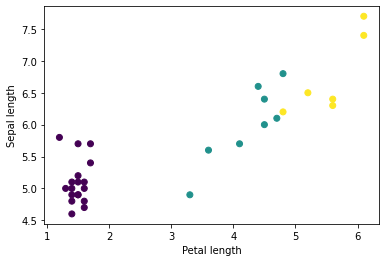

In [8]:
features, labels = next(iter(train_dataset))
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

In [9]:
def pack_features_vector(features, labels):
    """Pack the features into a single array."""
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

In [10]:
train_dataset = train_dataset.map(pack_features_vector)


In [11]:
#Create a model using Keras
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation= tf.nn.relu, input_shape=(4, )),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(3)
])

In [14]:
#Define the loss and gradient function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [16]:
def loss(model, x, y, training):
    y_ = model(x, training=training)
    return loss_object(y, y_)


In [17]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [18]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [19]:
#Training loop
# Keep results for plotting
train_loss_results = []
train_accuracy_results = []
num_epochs = 201

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    
    # Training loop - using batches of 32
    for x, y in train_dataset:
        # Optimize the model
        loss_value , grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # Track progress
        epoch_loss_avg.update_state(loss_value)
        epoch_accuracy.update_state(y, model(x, training=True))
    # End epoch
    
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.206, Accuracy: 35.000%
Epoch 050: Loss: 0.827, Accuracy: 70.000%
Epoch 100: Loss: 0.394, Accuracy: 90.833%
Epoch 150: Loss: 0.261, Accuracy: 98.333%
Epoch 200: Loss: 0.175, Accuracy: 98.333%


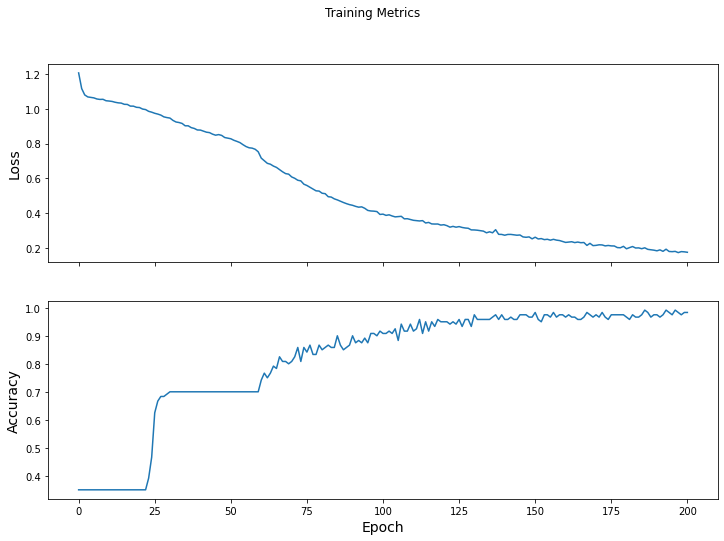

In [20]:
#Visualize the loss function over time
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

In [21]:
#Evaluate the model's effectiveness
#Setup the test dataset
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"
test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                 origin=test_url)
test_dataset = tf.data.experimental.make_csv_dataset(test_fp,
                                                    batch_size,
                                                    column_names=column_names,
                                                    label_name='species',
                                                    num_epochs=1,
                                                    shuffle=False)
test_dataset = test_dataset.map(pack_features_vector)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [22]:
#Evaluate the model on the test dataset
test_accuracy = tf.keras.metrics.Accuracy()
for (x, y) in test_dataset:
    # training=False is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    logits = model(x, training=False)
    prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
    test_accuracy(prediction, y)
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%
